# Computing Coursework

Dylan CHUA – 02131550, Chong Hui FENG – 02015459

## Importing Libraries

In [90]:
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Constants

In [92]:
T = 10
"""Ending Time (Expiry date)"""
R = 0.05
"""Risk-free interest rate"""
SD = 0.8
"""Volatility of stock"""
K = 2
"""Strike price"""

'Strike price'

## Domain of Solution and Discretised Grid

In [93]:
# Domains
# s = stock price
s_start = 0
s_end = 5
# tau = end time - current time
tau_start = 0
tau_end = T

# Grid
h = 0.5
"""mesh size in stock price"""
k = 0.01
"""time step in tau"""


# Coefficients
def coeffs():
    """precalculate common coefficients to reduce computations"""
    alpha = SD**2 / (2 * h**2)
    """coefficient for the second derivative in the stock price"""
    beta = R / h
    """coefficient for the first derivative in the stock price"""
    return alpha, beta


alpha, beta = coeffs()


def create_grid(h, k):
    """returns grid for s and tau as numpy arrays"""
    s = np.arange(s_start, s_end + h, h)
    t = np.arange(tau_start, tau_end + k, k)
    return s, t

## Arrays

In [94]:
s, t = create_grid(h, k)
num_s = len(s)
num_t = len(t)
S, T = np.meshgrid(s, t)
V = np.zeros((len(t), len(s)))

## Boundary Conditions

In [95]:
def init_conditions(V):
    """set the boundary conditions and initial values for the grid V"""
    # Boundary condition at t = 0, initial values
    V[0, :] = np.maximum(0, s - K)
    # Boundary condition at s = 0
    V[:, 0] = 0  # note: redundant step since np.zeros
    # Boundary condition at s tends to infinity
    V[:, -1] = s_end - K * np.exp(-R * t)

init_conditions(V)
print(V)

[[0.         0.         0.         ... 2.         2.5        3.        ]
 [0.         0.         0.         ... 0.         0.         3.00099975]
 [0.         0.         0.         ... 0.         0.         3.001999  ]
 ...
 [0.         0.         0.         ... 0.         0.         3.78572501]
 [0.         0.         0.         ... 0.         0.         3.786332  ]
 [0.         0.         0.         ... 0.         0.         3.78693868]]


## Plotting Methods

In [96]:
def surface_plot(value, fig=None, ax=None):
    """returns a surface plot of the value of the option"""
    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(S, T, value, cmap="viridis")
    ax.set_xlabel("Stock Price")
    ax.set_ylabel("Time to Expiry")
    ax.set_zlabel("Option Price")
    ax.view_init(30, -150)
    return fig, ax


def contour_plot(value, fig=None, ax=None):
    """returns a contour plot of the value of the option"""
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    CS = ax.contour(S, T, value, 20)
    ax.clabel(CS, inline=1, fontsize=10)
    ax.set_xlabel("Stock Price")
    ax.set_ylabel("Time to Expiry")
    return fig, ax


def value_time_plot(value, fig=None, ax=None):
    """returns a plot of the value of the option against time at different stock prices"""
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    for i in range(0, num_s, int(num_s / 5)):
        ax.plot(t, value[:, i], label=f"Stock Price: {s[i]:.2f}")
    ax.set_xlabel("Time to Expiry")
    ax.set_ylabel("Option Price")
    ax.legend()
    return fig, ax


def animated_plot(value, fig=None, ax=None):
    """returns an animated plot of the value of the option"""
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    (line,) = ax.plot(s, value[0, :])
    # show the time at the top of the plot
    ax.set_title(f"Time to Expiry: {t[0]:.2f}")
    # set the x and y axis labels
    ax.set_xlabel("Stock Price")
    ax.set_ylabel("Option Price")
    # set the x and y axis limits
    ax.set_xlim(s_start, s_end)
    ax.set_ylim(0, s_end - K)

    def animate(i):
        line.set_ydata(value[i, :])
        # update the time at the top of the plot
        ax.set_title(f"Time to Expiry: {t[i]:.2f}")
        # change the colour of the line based on the time
        line.set_color(plt.cm.viridis(i / num_t))
        return (line,)

    ani = animation.FuncAnimation(
        fig, animate, frames=num_t, interval=200, blit=True, save_count=50
    )
    return ani

## Numerical Method
$$ \frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2S^2\frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0 $$

To turn into forwards equation, substitute the time variable:
$$ \tau = T - t $$

$$ \frac{\partial V}{\partial t} = \frac{\partial V}{\partial \tau}\frac{\partial \tau}{\partial t} = -\frac{\partial V}{\partial \tau} $$

$$ -V_\tau + \frac{1}{2}\sigma^2S^2V_{SS} + rSV_S - rV = 0 $$

Substitute common coefficients to simplify calculations:

$$ \alpha = \frac{\sigma^2}{2h^2} $$
$$ \beta = \frac{r}{h} $$

### Explicit Method - Finite Difference

$$ V_\tau = \frac{1}{k} \left(V_{S,\tau+k} - V_{S,\tau}\right) $$

$$ V_S = \frac{1}{2h} \left(V_{S+h,\tau} - V_{S-h,\tau}\right) $$

$$ V_{SS} = \frac{1}{h^2} \left(V_{S+h,\tau} - 2V_{S,\tau} + V_{S-h,\tau}\right) $$

The PDE becomes:

$$ -\frac{V_{S,\tau+k} - V_{S,\tau}}{k} + \alpha S^2 \left(V_{S+h,\tau} - 2V_{S,\tau} + V_{S-h,\tau}\right) + \beta S \frac{V_{S+h,\tau} - V_{S-h,\tau}}{2} - rV_{S,\tau} = 0 $$

In [97]:
def explicit():
    """Explicit finite difference method for solving Black-Scholes PDE"""
    V_exp = V.copy()
    # Populating matrix from second row to second last row
    for i in range(1, num_t):  # time
        for j in range(1, num_s - 1):  # price
            # setting V[time = i, price = j] based on previous time step
            V_exp[i, j] = k * (
                ((alpha * s[j] ** 2) + beta * s[j] / 2) * V_exp[i - 1, j - 1]
                + ((1 / k) - 2 * alpha * s[j] ** 2 - R)
                * V_exp[i - 1, j]
                + ((alpha * s[j] ** 2) + beta * s[j] / 2) * V_exp[i - 1, j + 1]
            )
    return V_exp


V_exp = explicit()
"""values of option from explicit method"""
print(V_exp[:5,])

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.00000000e-01 1.00000000e+00 1.50000000e+00
  2.00000000e+00 2.50000000e+00 3.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.61000000e-02 5.01000000e-01 1.00250000e+00 1.50450000e+00
  2.00700000e+00 2.51000000e+00 3.00099975e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.71255000e-04
  4.95665100e-02 5.04163250e-01 1.00506460e+00 1.50909278e+00
  2.01412790e+00 2.51690253e+00 3.00199900e+00]
 [0.00000000e+00 0.00000000e+00 1.02576915e-05 2.19113546e-03
  7.08236973e-02 5.08933826e-01 1.00794216e+00 1.51377971e+00
  2.02070988e+00 2.52234819e+00 3.00299775e+00]
 [0.00000000e+00 3.53890357e-08 3.91320673e-05 4.15697385e-03
  9.02166618e-02 5.14899673e-01 1.01125899e+00 1.51849428e+00
  2.02668801e+00 2.52695007e+00 3.00399600e+00]]


### Implicit Method - Crank Nicolson

$$ V_\tau = \frac{1}{k} \left(V_{S,\tau+k} - V_{S,\tau}\right) $$
$$ V_S = \frac{1}{4h} \left(V_{S+h,\tau+k} - V_{S-h,\tau+k} + V_{S+h,\tau} - V_{S-h,\tau}\right) $$
$$ V_{SS} = \frac{1}{2h^2} \left(V_{S+h,\tau+k} - 2V_{S,\tau+k} + V_{S-h,\tau+k} + V_{S+h,\tau} - 2V_{S,\tau} + V_{S-h,\tau}\right) $$
$$ V = \frac{1}{2} \left(V_{S,\tau+k} + V_{S,\tau}\right) $$

The PDE becomes:

$$ -\frac{V_{S,\tau+k} - V_{S,\tau}}{k} \\ + \frac{1}{2}\sigma^2S^2\frac{V_{S+h,\tau+k} - 2V_{S,\tau+k} + V_{S-h,\tau+k} + V_{S+h,\tau} - 2V_{S,\tau} + V_{S-h,\tau}}{2h^2} \\ + rS\frac{V_{S+h,\tau+k} - V_{S-h,\tau+k} + V_{S+h,\tau} - V_{S-h,\tau}}{4h} \\ - r\frac{V_{S,\tau+k} + V_{S,\tau}}{2} \\ = 0 $$

Substitute $\alpha$ and $\beta$ to simplify calculations:

$$ -\frac{V_{S,\tau+k} - V_{S,\tau}}{k} \\ + \alpha S^2\frac{V_{S+h,\tau+k} - 2V_{S,\tau+k} + V_{S-h,\tau+k} + V_{S+h,\tau} - 2V_{S,\tau} + V_{S-h,\tau}}{2} \\ + \beta S\frac{V_{S+h,\tau+k} - V_{S-h,\tau+k} + V_{S+h,\tau} - V_{S-h,\tau}}{4} \\ - r\frac{V_{S,\tau+k} + V_{S,\tau}}{2} \\ = 0 $$


In [98]:
def implicit():
    """Cranks-Nicolson method for solving the Black-Scholes PDE"""
    V_imp = V.copy()
    for i, t_curr in enumerate(t[:-1]):
        # Constructing the matrix A and B
        A = np.zeros((num_s, num_s))
        B = np.zeros((num_s, 1))
        # Boundary condition at s tends to infinity
        A[-1, -1] = 1
        B[-1, 0] = s_end - K * np.exp(-R * t_curr)
        for j, s_curr in enumerate(s[:-1]):
            if j == 0:
                # Boundary condition at s = 0
                A[j, j] = 1
                B[j, 0] = 0
                continue
            # Coefficients for the implicit method
            A[j, j - 1] = alpha * s_curr**2 / 2 - beta * s_curr / 4
            A[j, j] = -1 / k - alpha * s_curr**2 - R / 2
            A[j, j + 1] = alpha * s_curr**2 / 2 + beta * s_curr / 4
            B[j, 0] = (
                -V_imp[i, j] / k
                - alpha
                * s_curr**2
                / 2
                * (V_imp[i, j + 1] - 2 * V_imp[i, j] + V_imp[i, j - 1])
                - beta * s_curr / 4 * (V_imp[i, j + 1] - V_imp[i, j - 1])
                + R / 2 * V_imp[i, j]
            )
        # Solving the system of equations
        V_imp[i + 1, :] = np.linalg.solve(A, B).flatten()
    return V_imp


V_imp = implicit()
"""values of option from implicit method"""
print(V_imp[:5,])

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.00000000e-01 1.00000000e+00 1.50000000e+00
  2.00000000e+00 2.50000000e+00 3.00000000e+00]
 [0.00000000e+00 4.03117310e-09 2.34497429e-06 3.57225776e-04
  2.48778542e-02 5.01871781e-01 1.00104432e+00 1.50100213e+00
  2.00099097e+00 2.50089509e+00 3.00000000e+00]
 [0.00000000e+00 3.15238418e-08 1.36639147e-05 1.37625358e-03
  4.74849789e-02 5.05280788e-01 1.00224713e+00 1.50201725e+00
  2.00196248e+00 2.50172535e+00 3.00099975e+00]
 [0.00000000e+00 1.26608317e-07 4.17737847e-05 2.95943957e-03
  6.81400875e-02 5.09860682e-01 1.00371620e+00 1.50306833e+00
  2.00292510e+00 2.50261833e+00 3.00199900e+00]
 [0.00000000e+00 3.57597798e-07 9.31015727e-05 5.02325720e-03
  8.71102238e-02 5.15327025e-01 1.00550659e+00 1.50418514e+00
  2.00389896e+00 2.50354831e+00 3.00299775e+00]]


## Results

The values obtained from the explicit and implicit method are ploted using a 3D surface plot, a contour plot, a 2D value against time for different stock prices plot, and an animated plot (best viewed in .py not .ipynb)

### Explicit Method

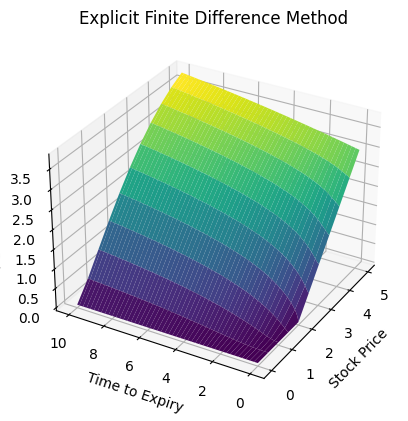

In [99]:
fig, ax = surface_plot(V_exp)
ax.set_title("Explicit Finite Difference Method")
plt.show()

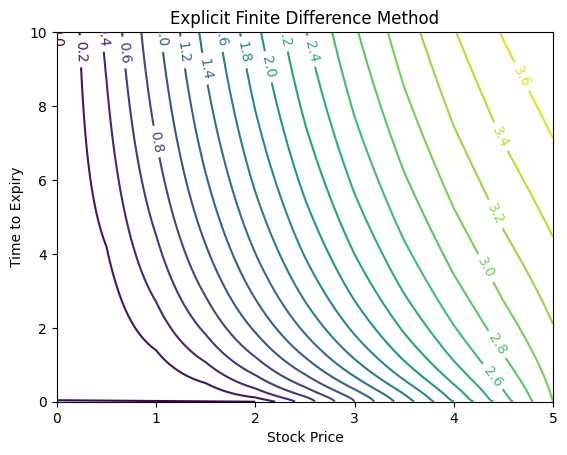

In [100]:
fig, ax = contour_plot(V_exp)
ax.set_title("Explicit Finite Difference Method")
plt.show()

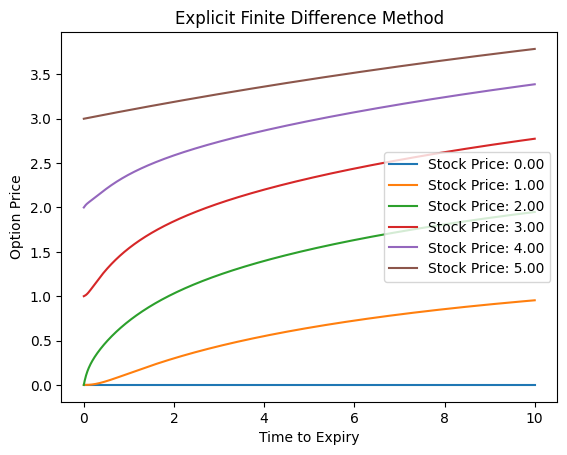

In [101]:
fig, ax = value_time_plot(V_exp)
ax.set_title("Explicit Finite Difference Method")
plt.show()

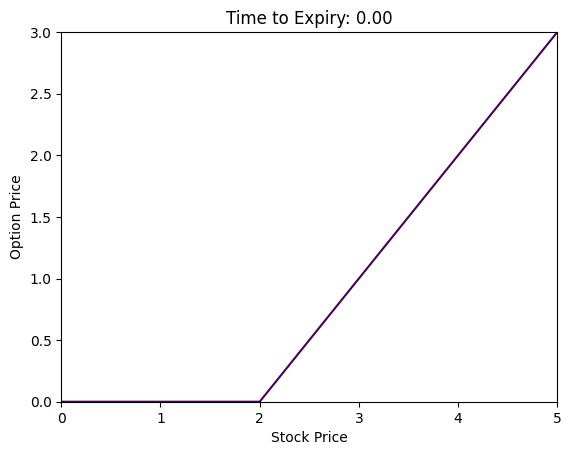

In [102]:
ani = animated_plot(V_exp)
# ani.save("explicit.gif", writer="ffmpeg", fps=10)
plt.show()

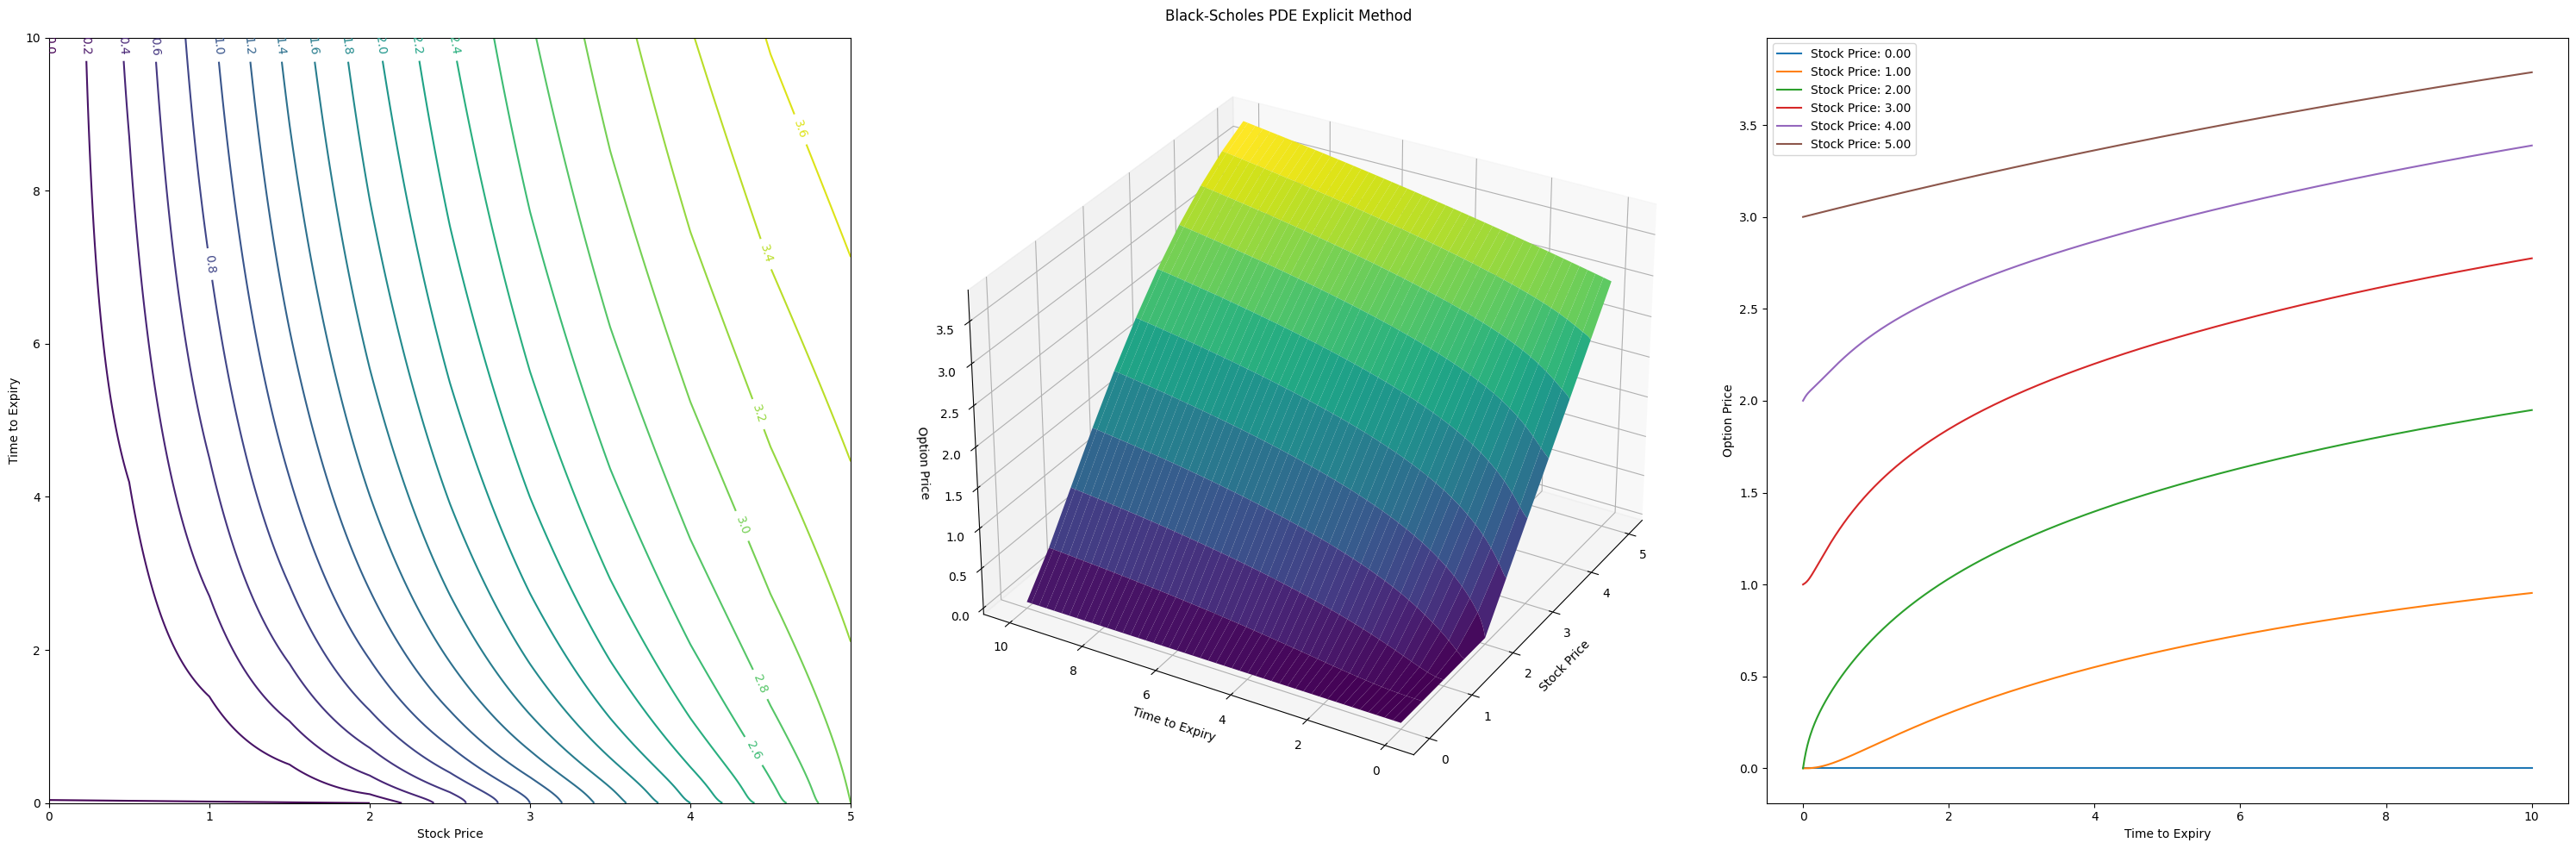

In [103]:
# combined plot
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Black-Scholes PDE Explicit Method")
surf_ax = fig.add_subplot(132, projection="3d")
surface_plot(V_exp, fig, surf_ax)
contour_ax = fig.add_subplot(131)
contour_plot(V_exp, fig, contour_ax)
value_time_ax = fig.add_subplot(133)
value_time_plot(V_exp, fig, value_time_ax)
# ani_ax = fig.add_subplot(224)
# animated_plot(V_exp, fig, ani_ax)
fig.tight_layout()
fig.savefig("explicit.png")
plt.show()

### Implicit Method

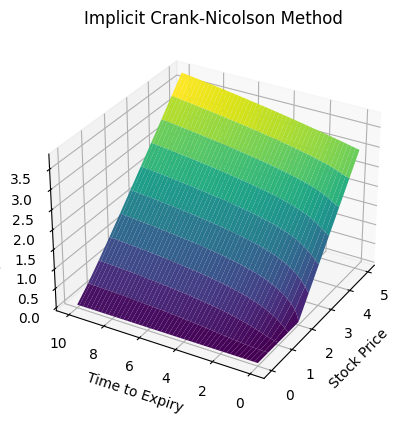

In [79]:
fig, ax = surface_plot(V_imp)
ax.set_title("Implicit Crank-Nicolson Method")
plt.show()

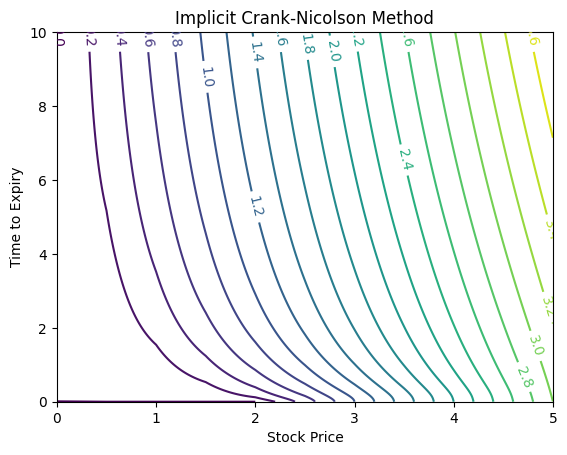

In [80]:
fig, ax = contour_plot(V_imp)
ax.set_title("Implicit Crank-Nicolson Method")
plt.show()

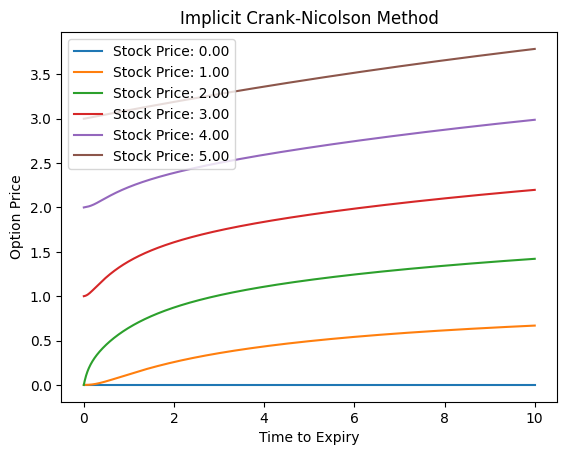

In [81]:
fig, ax = value_time_plot(V_imp)
ax.set_title("Implicit Crank-Nicolson Method")
plt.show()

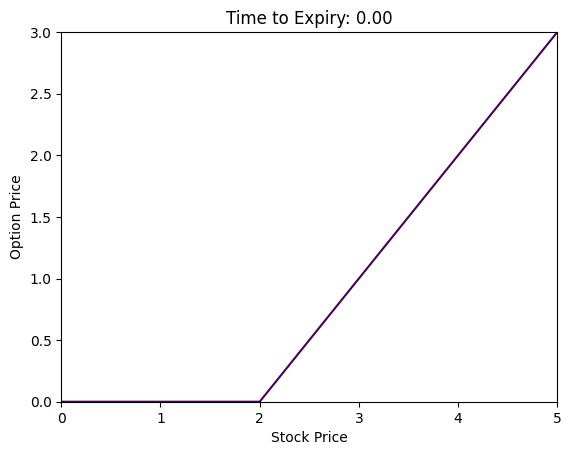

In [82]:
ani = animated_plot(V_imp)
# ani.save("implicit.gif", writer="ffmpeg", fps=10)
plt.show()

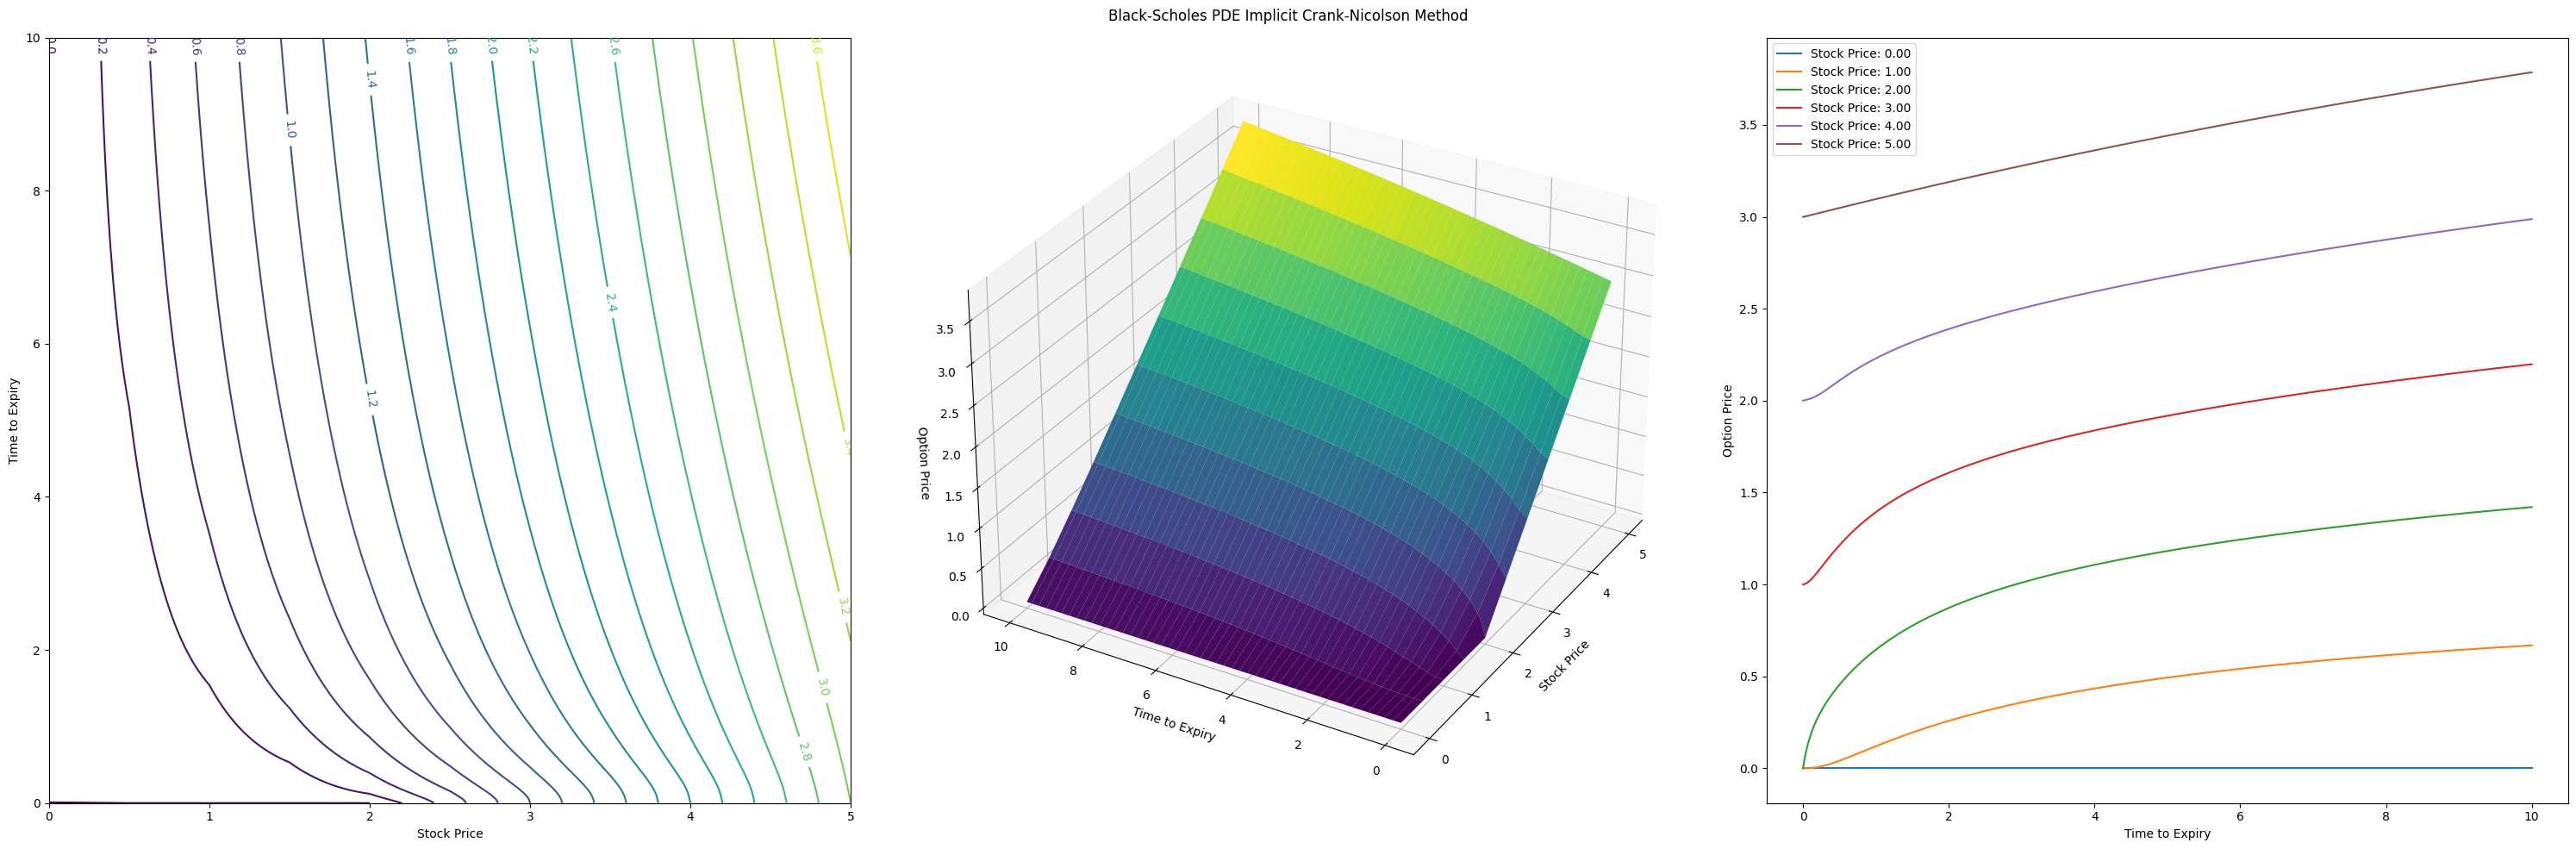

In [83]:
# combined plot
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Black-Scholes PDE Implicit Crank-Nicolson Method")
surf_ax = fig.add_subplot(132, projection="3d")
surface_plot(V_imp, fig, surf_ax)
contour_ax = fig.add_subplot(131)
contour_plot(V_imp, fig, contour_ax)
value_time_ax = fig.add_subplot(133)
value_time_plot(V_imp, fig, value_time_ax)
# ani_ax = fig.add_subplot(224)
# animated_plot(V_imp, fig, ani_ax)
fig.tight_layout()
plt.savefig("implicit.png")
plt.show()

## Finer Mesh

In [84]:
h = 0.01
k = 0.01
alpha, beta = coeffs()
s, t = create_grid(h, k)
num_s = len(s)
num_t = len(t)
S, T = np.meshgrid(s, t)
V = np.zeros((len(t), len(s)))
init_conditions(V)

C:\Users\user\AppData\Local\Temp\ipykernel_4768\1765127989.py:9: RuntimeWarning: overflow encountered in double_scalars
  ((alpha * s[j] ** 2) + beta * s[j] / 2) * V_exp[i - 1, j - 1]
C:\Users\user\AppData\Local\Temp\ipykernel_4768\1765127989.py:10: RuntimeWarning: overflow encountered in double_scalars
  + ((1 / k) - 2 * alpha * s[j] ** 2 - R)
C:\Users\user\AppData\Local\Temp\ipykernel_4768\1765127989.py:12: RuntimeWarning: overflow encountered in double_scalars
  + ((alpha * s[j] ** 2) + beta * s[j] / 2) * V_exp[i - 1, j + 1]
C:\Users\user\AppData\Local\Temp\ipykernel_4768\1765127989.py:9: RuntimeWarning: invalid value encountered in double_scalars
  ((alpha * s[j] ** 2) + beta * s[j] / 2) * V_exp[i - 1, j - 1]


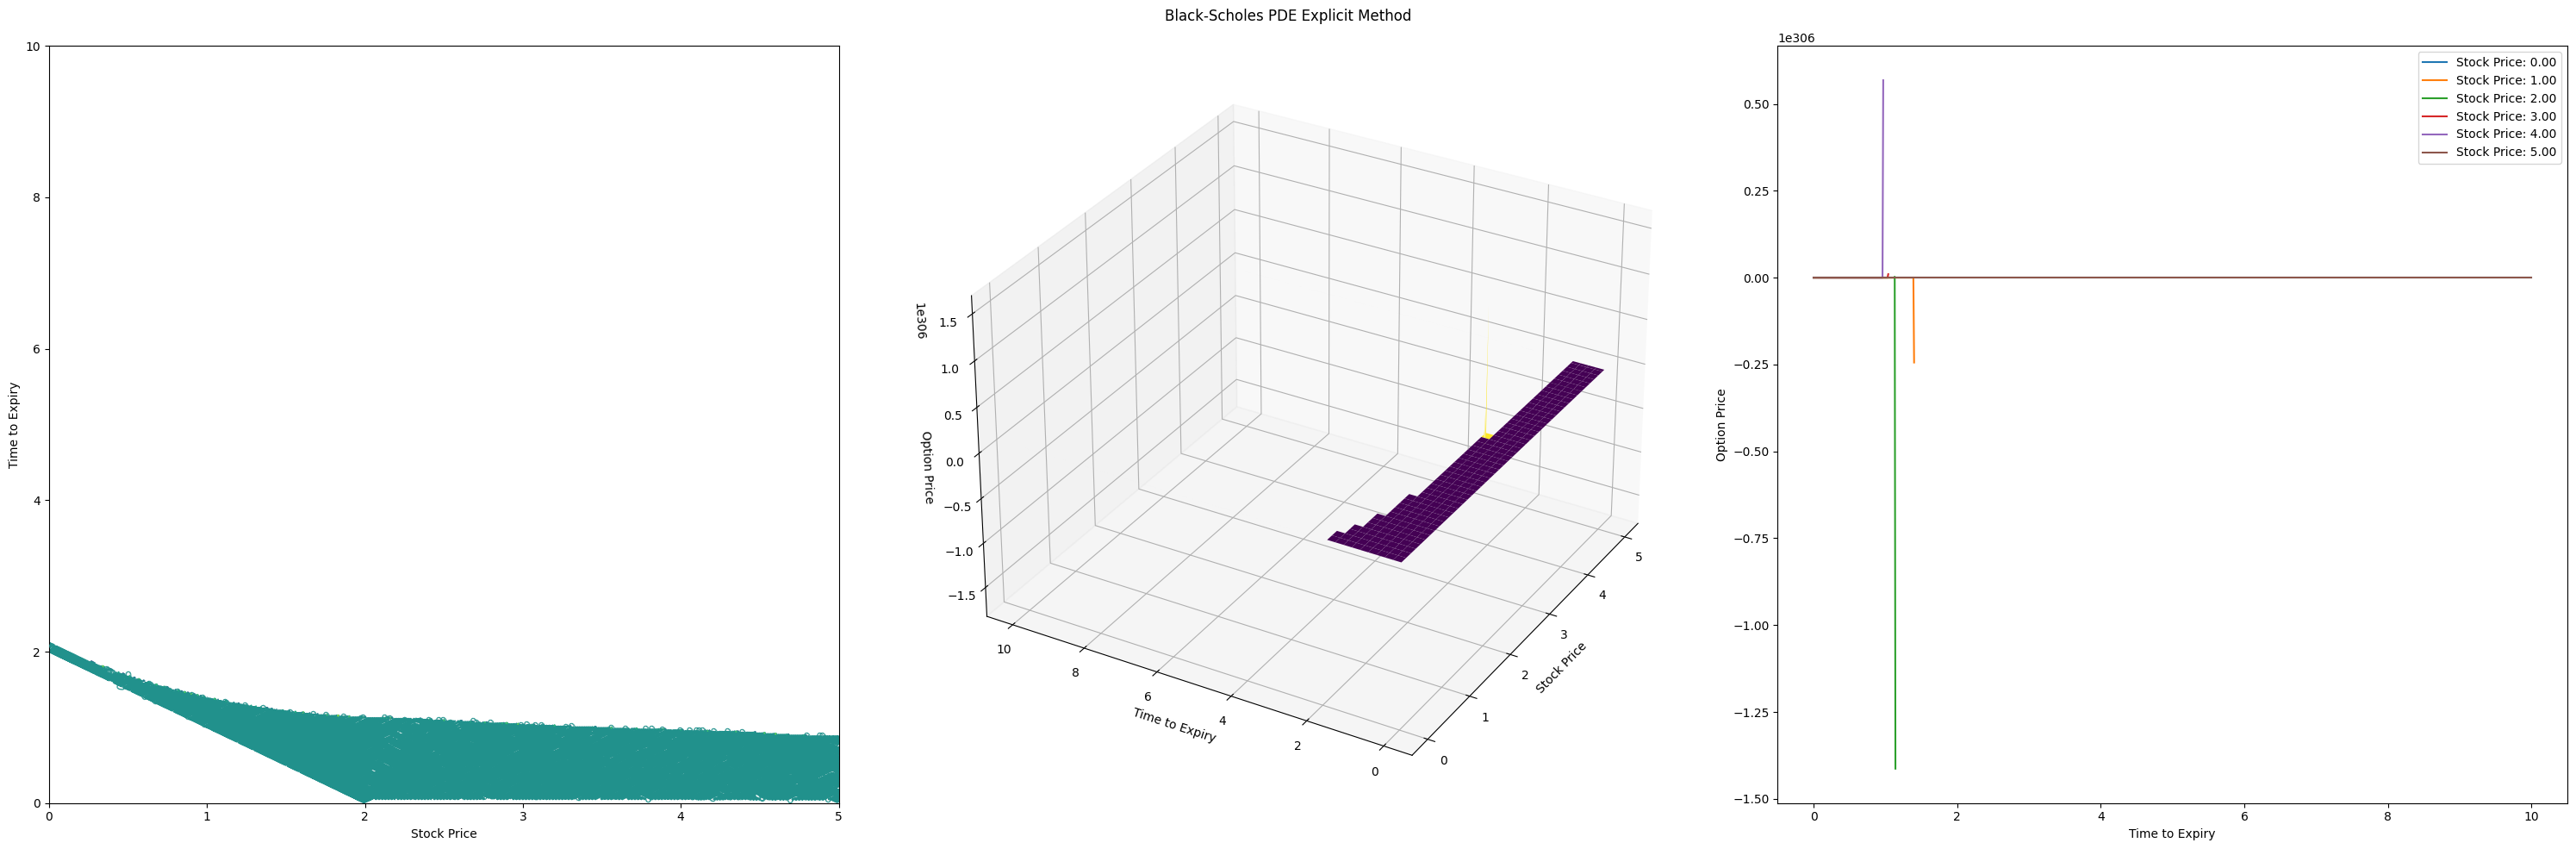

In [85]:
V_exp = explicit()
# combined plot
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Black-Scholes PDE Explicit Method")
surf_ax = fig.add_subplot(132, projection="3d")
surface_plot(V_exp, fig, surf_ax)
contour_ax = fig.add_subplot(131)
contour_plot(V_exp, fig, contour_ax)
value_time_ax = fig.add_subplot(133)
value_time_plot(V_exp, fig, value_time_ax)
# ani_ax = fig.add_subplot(224)
# animated_plot(V_exp, fig, ani_ax)
fig.tight_layout()
plt.savefig("explicit_fine.png")
plt.show()

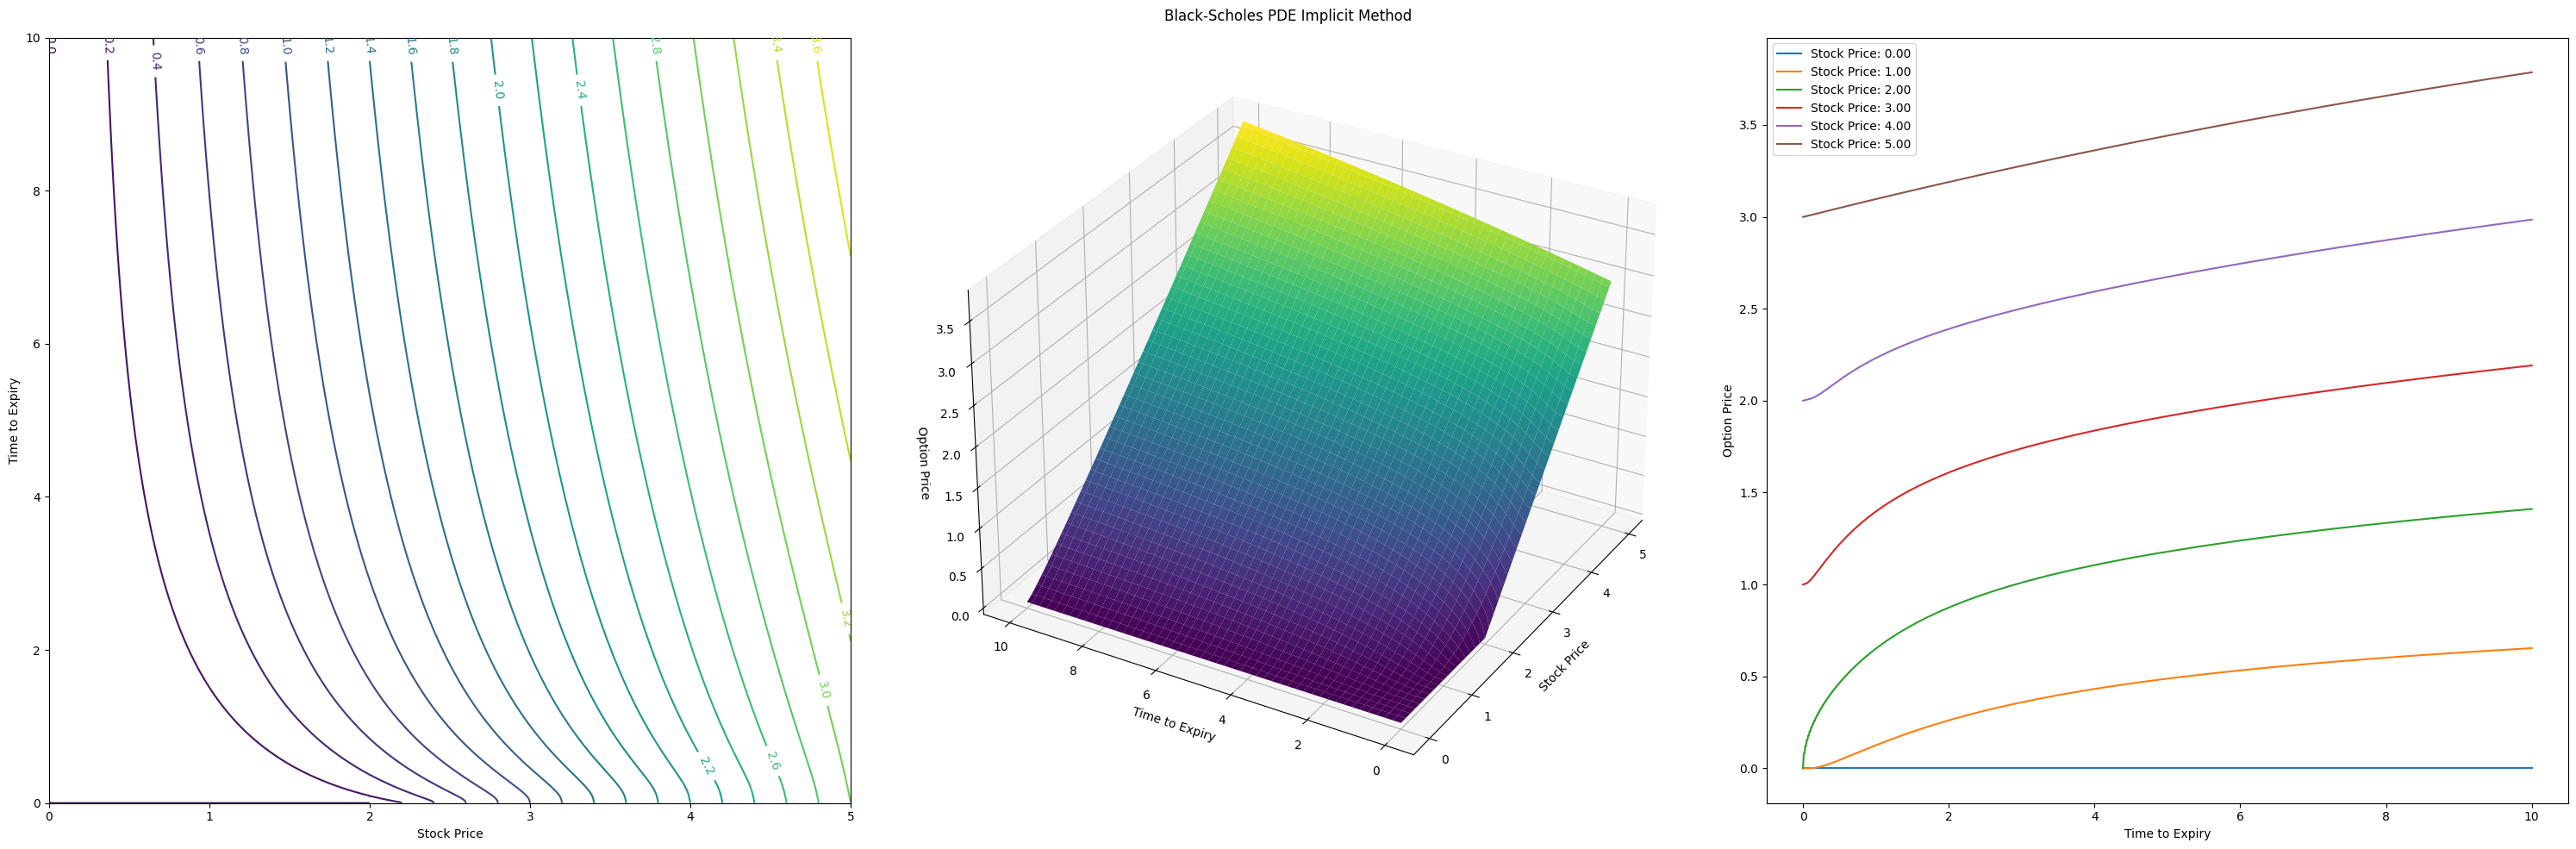

In [89]:
V_imp = implicit()
# combined plot
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Black-Scholes PDE Implicit Method")
surf_ax = fig.add_subplot(132, projection="3d")
surface_plot(V_imp, fig, surf_ax)
contour_ax = fig.add_subplot(131)
contour_plot(V_imp, fig, contour_ax)
value_time_ax = fig.add_subplot(133)
value_time_plot(V_imp, fig, value_time_ax)
# ani_ax = fig.add_subplot(224)
# animated_plot(V_imp, fig, ani_ax)
fig.tight_layout()
plt.savefig("implicit_fine.png")
plt.show()